# Example of a one-dimensional constrained Gaussian Process

In [35]:
import torch
import gpytorch
from src.models.constrained_gp_model import ConstrainedGPAgrell
import matplotlib.pyplot as plt

In [36]:
# Objective function
def objective_func(x):
    return 0.4 * torch.square(x) - 6

In [37]:
noise = 0.05

# define train points
x_train = torch.Tensor([[-2], [1], [2], [3]])
y_train = objective_func(x_train) + torch.normal(mean=0, std=torch.ones_like(x_train[1])*noise,)

# define test points
x_test = torch.linspace(-8, 8, 100).reshape(-1, 1)

# define virtual observation locations
xv_points = torch.linspace(-3.5, 3.5, 10).reshape(-1, 1)

In [38]:
constrained_dims = [] # list of constrained dimensions

model_unconstrained = ConstrainedGPAgrell(
    x_train,
    y_train,
    constrained_dims=constrained_dims,
    lengthscale_constraint=gpytorch.constraints.Interval(0, 4),
    lengthscale_hyperprior=gpytorch.priors.NormalPrior(1, 2),  # lengthscale = hyperprior.mean if not trained
    outputscale_constraint=gpytorch.constraints.Interval(0, 10),
    outputscale_hyperprior=gpytorch.priors.NormalPrior(4, 2),
    prior_mean=-2.)
model_unconstrained.likelihood.noise_covar.noise = noise ** 2

In [39]:
# unconstrained GP
prediction_unconstrained = model_unconstrained.posterior(X=x_test)
unconstrained_mean = prediction_unconstrained.mean.detach().numpy().reshape(-1)
unconstrained_std = torch.sqrt(prediction_unconstrained.variance.detach()).numpy().reshape(-1)


In [40]:
constrained_dims = [0] # list of constrained dimensions

model_constrained = ConstrainedGPAgrell(
    x_train,
    y_train,
    constrained_dims=constrained_dims,
    lengthscale_constraint=gpytorch.constraints.Interval(0, 4),
    lengthscale_hyperprior=gpytorch.priors.NormalPrior(1, 2),  # lengthscale = hyperprior.mean if not trained
    outputscale_constraint=gpytorch.constraints.Interval(0, 10),
    outputscale_hyperprior=gpytorch.priors.NormalPrior(4, 2),
    prior_mean=-2.)
model_constrained.likelihood.noise_covar.noise = noise ** 2


In [41]:
posterior_options = {'evaluate_constrained': True,
                     'virtual_oberservation_points': xv_points,
                     'nr_samples': 10000}

# constrained GP
prediction_constrained = model_constrained.posterior(X=x_test, observation_noise=False, **posterior_options)
constrained_mean = prediction_constrained.mean.detach().numpy().reshape(-1)
constrained_std = torch.sqrt(prediction_constrained.variance.detach()).numpy().reshape(-1)

Start minimax algorithm (Python implementation) for 10000 samples (D=10)...
Time taken for 10000 samples: 0.05s.


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


In [42]:
# get samples from unconstrained model
samples_unconstrained = model_unconstrained.get_samples_from_last_posterior(3)

# get samples from constrained model
samples_constrained = model_constrained.get_samples_from_last_posterior(3)

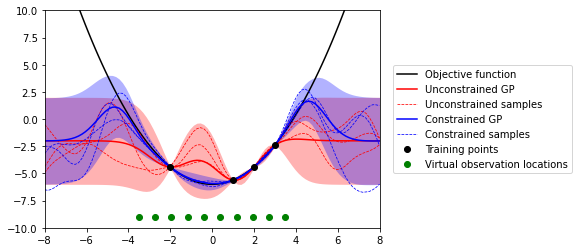

In [45]:
plt.plot(x_test.numpy(), objective_func(x_test).numpy(),'k-', label='Objective function')

# unconstrained posterior
plt.plot(x_test.numpy().reshape(-1), unconstrained_mean,'r-',label='Unconstrained GP')
plt.fill_between(x_test.numpy().reshape(-1), unconstrained_mean - 2 * unconstrained_std,
                 unconstrained_mean + 2 * unconstrained_std,
                 alpha=0.3, color='r', lw=0)
plt.plot(x_test.numpy().reshape(-1), samples_unconstrained,'r--',linewidth=0.75,
         label=['Unconstrained samples',None,None])

# constrained posterior
plt.plot(x_test.numpy().reshape(-1), constrained_mean,'b-', label='Constrained GP')
plt.fill_between(x_test.numpy().reshape(-1), constrained_mean - 2 * constrained_std,
                 constrained_mean + 2 * constrained_std,
                 alpha=0.3, color='b', lw=0)
plt.plot(x_test.numpy().reshape(-1), samples_constrained,'b--',linewidth=0.75,
         label=['Constrained samples',None,None])

plt.plot(x_train.numpy(), y_train.numpy(),'ko', label='Training points')
plt.plot(xv_points, torch.ones(xv_points.shape[0]) * -9, 'go', label='Virtual observation locations')
plt.xlim([x_test[0], x_test[-1]])
plt.ylim([-10, 10])
plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)
plt.show()
plt.close()